In [3]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/kaggle/setup_rapids.sh stable


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 9.28 MiB/s, done.
Resolving deltas: 100% (299/299), done.
bash: rapidsai-csp-utils/kaggle/setup_rapids.sh: No such file or directory


In [2]:
import pandas as pd
import numpy as np
import dateutil.parser


# Load your data
depth_df = pd.read_csv('/kaggle/input/depthdata/depth.csv')     # Example filename
trade_df = pd.read_csv('/kaggle/input/aggtrade/aggTrade.csv')    # Trade volume data



# Helper to safely parse timestamp
def clean_timestamp(ts):
    try:
        # Remove timezone manually and limit microseconds to 6 digits
        if '+' in ts:
            ts = ts.split('+')[0].strip()
        if '.' in ts:
            main, micro = ts.split('.')
            micro = micro[:6]  # Keep only 6 digits for microseconds
            ts = f"{main}.{micro}"
        return pd.to_datetime(ts, format="%Y-%m-%d %H:%M:%S.%f")
    except Exception as e:
        print(f"Error parsing {ts}: {e}")
        return pd.NaT

# Apply to your column
depth_df['timestamp'] = depth_df['Time'].apply(clean_timestamp)
#depth_df.set_index('timestamp', inplace=True)

trade_df['timestamp'] = trade_df['Time'].apply(clean_timestamp)
#trade_df.set_index('timestamp', inplace=True)


depth_df.head()


,Time,BidPriceL20,BidQtyL20,BidPriceL19,BidQtyL19,BidPriceL18,BidQtyL18,BidPriceL17,BidQtyL17,BidPriceL16,...,AskQtyL16,AskPriceL17,AskQtyL17,AskPriceL18,AskQtyL18,AskPriceL19,AskQtyL19,AskPriceL20,AskQtyL20,timestamp
0,2025-03-14 00:00:02.292522546 +0530 IST,579.20,0.621,579.24,0.015,579.25,0.009,579.26,0.013,579.27,...,1.151,579.68,0.043,579.69,1.258,579.70,0.911,579.71,2.025,2025-03-14 00:00:02.292522
1,2025-03-14 00:00:03.292828523 +0530 IST,579.08,2.612,579.09,8.606,579.10,3.453,579.11,3.825,579.12,...,0.971,579.60,5.071,579.61,4.894,579.62,1.017,579.63,0.048,2025-03-14 00:00:03.292828
2,2025-03-14 00:00:04.292889586 +0530 IST,579.14,1.948,579.15,3.957,579.18,1.681,579.19,3.465,579.20,...,1.017,579.63,0.048,579.64,9.720,579.65,2.025,579.66,0.365,2025-03-14 00:00:04.292889
3,2025-03-14 00:00:05.292551566 +0530 IST,579.07,0.013,579.08,0.013,579.09,8.606,579.10,3.453,579.11,...,0.024,579.57,1.926,579.58,2.127,579.59,0.279,579.60,7.213,2025-03-14 00:00:05.292551
4,2025-03-14 00:00:06.292725093 +0530 IST,579.11,9.143,579.12,6.361,579.13,5.837,579.14,2.816,579.15,...,0.024,579.57,1.926,579.58,2.127,579.59,0.279,579.60,10.469,2025-03-14 00:00:06.292725


In [3]:
def compute_features():
    df = pd.DataFrame(index=depth_df.index)

    # Mid price, spread
    df['mid_price'] = (depth_df['AskPriceL1'] + depth_df['BidPriceL1']) / 2
    df['spread'] = depth_df['AskPriceL1'] - depth_df['BidPriceL1']

    # Imbalance & Microprice
    df['imbalance'] = (depth_df['BidQtyL1'] - depth_df['AskQtyL1']) / (depth_df['BidQtyL1'] + depth_df['AskQtyL1'])
    df['microprice'] = (
        depth_df['BidPriceL1'] * depth_df['AskQtyL1'] + depth_df['AskPriceL1'] * depth_df['BidQtyL1']
    ) / (depth_df['BidQtyL1'] + depth_df['AskQtyL1'])

    # Rolling returns and volatility
    df['log_return'] = np.log(df['mid_price'] / df['mid_price'].shift(1))
    df['volatility_10s'] = df['log_return'].rolling(window=10).std()
    df['volatility_30s'] = df['log_return'].rolling(window=30).std()

    # Cumulative volume features
    # Tag buy/sell side
    trade_df['side'] = trade_df['IsMarketMaker'].apply(lambda x: 'sell' if x else 'buy')
    
    # Set timestamp as index (rounded to seconds)
    trade_df['second'] = trade_df['timestamp'].dt.floor('s')
    
    # Compute per-second volume stats
    volume_stats = trade_df.groupby(['second', 'side'])['Quantity'].sum().unstack(fill_value=0)
    
    df['volume_imbalance'] = (volume_stats['buy'] - volume_stats['sell']) / (volume_stats['buy'] + volume_stats['sell'] + 1e-2)  # small epsilon to avoid div by 0
    
    # Optionally, calculate cumulative volume too
    df['cum_volume_10s'] = volume_stats['buy'].rolling(window=10).sum() + volume_stats['sell'].rolling(window=10).sum()
    df['cum_volume_30s'] = volume_stats['buy'].rolling(window=30).sum() + volume_stats['sell'].rolling(window=30).sum()
    # print(df)
    
    df = df.dropna(axis=1, how='all')

    df.fillna(0, inplace=True)

    
    return df


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mid_price,spread,imbalance,microprice,log_return,volatility_10s,volatility_30s
0,579.480,0.08,0.000000,579.480000,0.000000,0.000000,0.000000
1,579.400,0.08,0.000000,579.400000,-0.000138,0.000000,0.000000
2,579.410,0.08,-0.098286,579.406069,0.000017,0.000000,0.000000
3,579.340,0.06,0.000000,579.340000,-0.000121,0.000000,0.000000
4,579.345,0.05,0.000000,579.345000,0.000009,0.000000,0.000000
5,579.315,0.07,0.000000,579.315000,-0.000052,0.000000,0.000000
6,579.345,0.09,0.000000,579.345000,0.000052,0.000000,0.000000
7,579.345,0.05,0.000000,579.345000,0.000000,0.000000,0.000000
8,579.345,0.07,0.000000,579.345000,0.000000,0.000000,0.000000
9,579.415,0.05,-0.494361,579.402641,0.000121,0.000000,0.000000


In [21]:
from cuml.cluster import KMeans as cuKMeans
from sklearn.preprocessing import StandardScaler
import cupy as cp
import pandas as pd


def normalize_and_reduce(features_df):
    # Step 1: Scale on CPU using sklearn (still fast and simple)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)
    
    # Step 2: Convert to GPU array (CuPy)
    features_gpu = cp.asarray(features_scaled)
    
    # Step 3: Apply cuML KMeans on GPU
    kmeans_gpu = cuKMeans(n_clusters=6, max_iter=300,n_init=10, random_state=42)
    labels_gpu = kmeans_gpu.fit_predict(features_gpu)
    
    # Step 4: Convert labels back to CPU (for Pandas/Numpy operations)
    labels = cp.asnumpy(labels_gpu)
    return features_scaled,labels


In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    embedding = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10')
    plt.title("t-SNE Clustering")
    plt.show()

def plot_regime_timeseries(df):
    plt.figure(figsize=(15, 4))
    plt.plot(df.index, df['mid_price'], label='Mid Price')
    plt.scatter(df.index, df['regime'], c=df['regime'], cmap='tab10', marker='|', s=100, label='Regime')
    plt.legend()
    plt.title("Market Regimes Over Time")
    plt.show()


In [8]:
def compute_transition_matrix(labels):
    unique = np.unique(labels)
    matrix = np.zeros((len(unique), len(unique)))

    for (a, b) in zip(labels[:-1], labels[1:]):
        matrix[a, b] += 1

    # Normalize rows
    matrix = matrix / matrix.sum(axis=1, keepdims=True)
    return pd.DataFrame(matrix, index=unique, columns=unique)


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


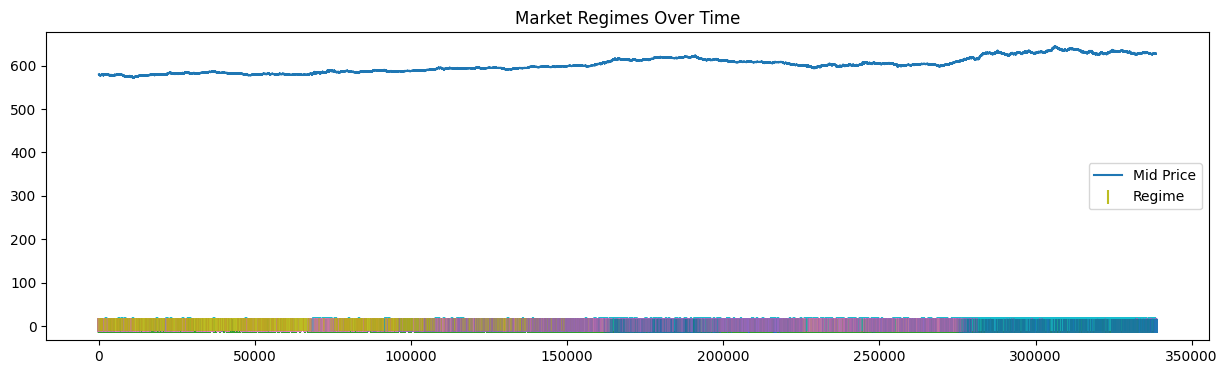

Transition Matrix:
           0         1         2         3         4         5
0  0.882394  0.050138  0.043290  0.010814  0.000000  0.013364
1  0.239484  0.119700  0.096097  0.367529  0.047374  0.129815
2  0.020664  0.019404  0.880782  0.031745  0.047010  0.000395
3  0.021808  0.082777  0.099761  0.689517  0.100254  0.005883
4  0.000000  0.007676  0.048724  0.035466  0.908078  0.000057
5  0.096651  0.102174  0.000534  0.034919  0.000000  0.765722


In [22]:
features_df = compute_features()
features_scaled, labels = normalize_and_reduce(features_df)
features_df['regime'] = labels


plot_regime_timeseries(features_df)

transition_matrix = compute_transition_matrix(labels)
print("Transition Matrix:\n", transition_matrix)
